🔄 Đang load dữ liệu...
Phân bố lớp: [14000. 14000. 14000. 14000. 14000. 14000. 13999. 14000. 14000. 14000.
 14000.]
✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 35, 32)            3360      
                                                                 
 batch_normalization (BatchN  (None, 35, 32)           128       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 35, 64)            18816     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 64)           256       
 hNormalization)                                                 
                                                                 
 gru_2 (GRU)   

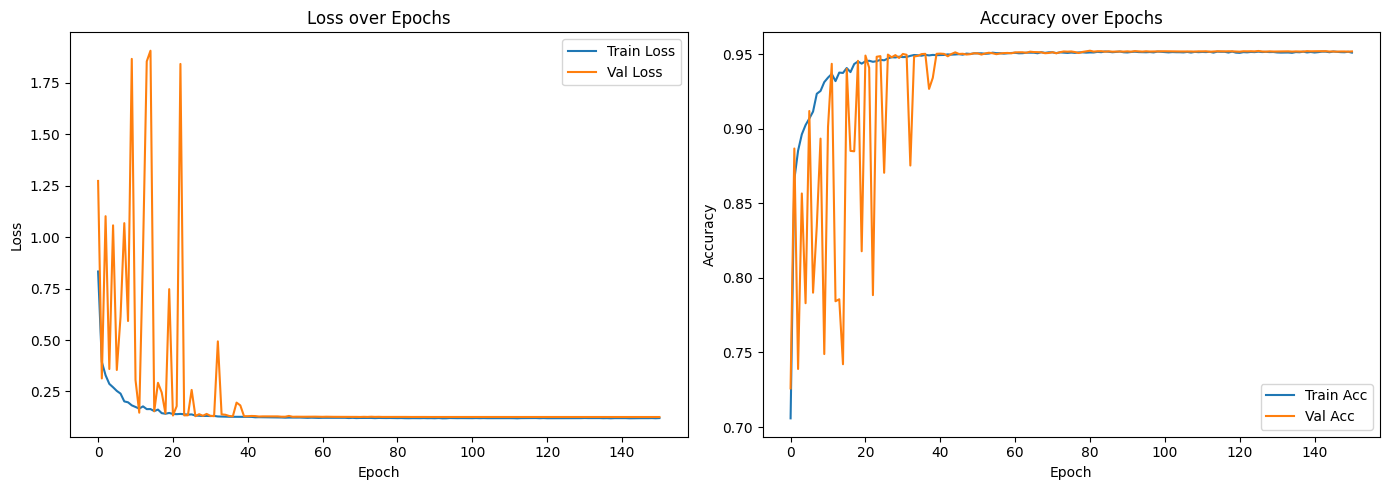

🔎 Dự đoán trên tập test...
172/172 [==============================] - 2s 5ms/step
📊 Ma trận nhầm lẫn:


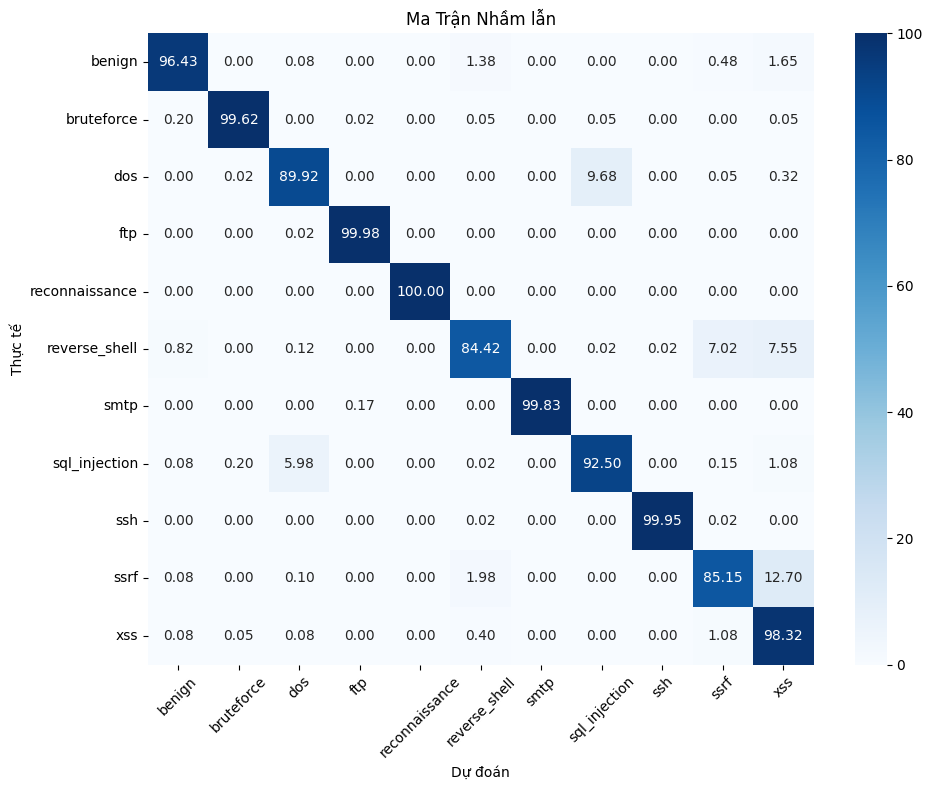


📋 Classification Report:
                precision    recall  f1-score   support

        benign     0.9872    0.9643    0.9756      4000
    bruteforce     0.9972    0.9962    0.9967      4000
           dos     0.9338    0.8992    0.9162      4000
           ftp     0.9980    0.9998    0.9989      4000
reconnaissance     1.0000    1.0000    1.0000      4000
 reverse_shell     0.9564    0.8442    0.8968      4000
          smtp     1.0000    0.9983    0.9991      4001
 sql_injection     0.9046    0.9250    0.9147      4000
           ssh     0.9997    0.9995    0.9996      4000
          ssrf     0.9063    0.8515    0.8781      4000
           xss     0.8081    0.9832    0.8871      4000

      accuracy                         0.9510     44001
     macro avg     0.9538    0.9510    0.9512     44001
  weighted avg     0.9538    0.9510    0.9512     44001


📈 ROC-AUC từng lớp:
Class benign - AUC: 0.9990
Class bruteforce - AUC: 0.9997
Class dos - AUC: 0.9969
Class ftp - AUC: 1.0000
Clas

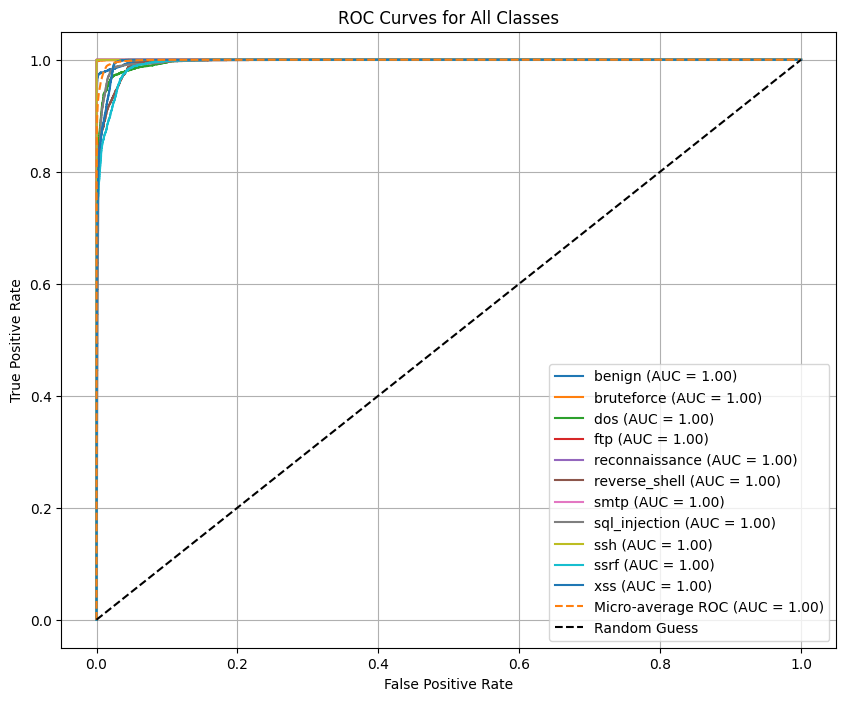


📊 F1-Score từng lớp:


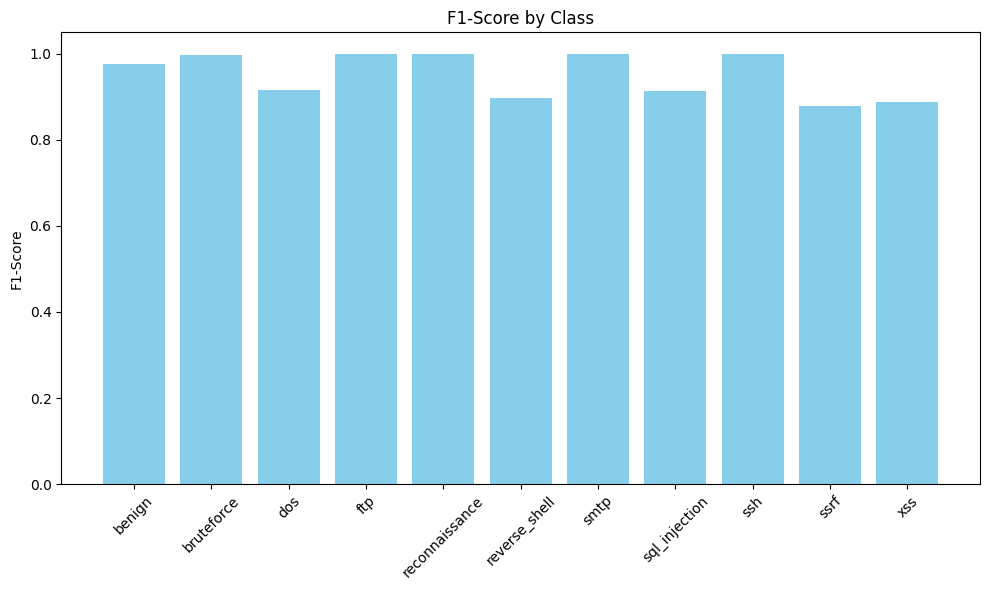


✅ Test Accuracy: 0.9510 - Test Loss: 0.1324
💾 Mô hình đã được lưu vào: lstm_webids23_model.h5


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU  
from sklearn.preprocessing import StandardScaler

# ==== 1. Tên lớp gộp ====
class_names = [
    'benign', 'bruteforce', 'dos', 'ftp', 'reconnaissance',
    'reverse_shell', 'smtp', 'sql_injection', 'ssh', 'ssrf', 'xss'
]

# ==== 2. Hàm reshape an toàn ====
def safe_reshape(X, n_features=35):
    if len(X.shape) == 1:
        assert X.size % n_features == 0, "Tổng phần tử không chia hết cho số đặc trưng"
        X = X.reshape(-1, n_features)
    elif X.shape[1] != n_features:
        raise ValueError(f"Số đặc trưng không đúng. Mong đợi {n_features}, nhưng nhận được {X.shape[1]}")
    return X.reshape(-1, n_features, 1)

# ==== 3. Load và xử lý dữ liệu ====
def load_data(data_path):
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val   = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val   = np.load(os.path.join(data_path, 'y_val.npy'))
    X_test  = np.load(os.path.join(data_path, 'X_test.npy'))
    y_test  = np.load(os.path.join(data_path, 'y_test.npy'))

    # Kiểm tra NaN hoặc Inf
    def check_data(X, name="Data"):
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            raise ValueError(f"{name} contains NaN or Inf values")
    check_data(X_train, "X_train")
    check_data(X_val, "X_val")
    check_data(X_test, "X_test")

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

    X_train = safe_reshape(X_train, n_features=35)
    X_val   = safe_reshape(X_val, n_features=35)
    X_test  = safe_reshape(X_test, n_features=35)

    print("Phân bố lớp:", np.sum(y_train, axis=0))
    return X_train, y_train, X_val, y_val, X_test, y_test

# ==== 4. Xây dựng mô hình GRU ====

def build_gru_model(input_shape=(35, 1), num_classes=11):
    model = Sequential()

    # Tầng GRU 1
    model.add(GRU(32, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())

    # Tầng GRU 2
    model.add(GRU(64, return_sequences=True))
    model.add(BatchNormalization())

    # Tầng GRU 3
    model.add(GRU(128))
    model.add(BatchNormalization())

    # Tầng Dense
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


# ==== 5. Biểu đồ training ====
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

# ==== 6. Ma trận nhầm lẫn ====
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_percent * 100, 2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma Trận Nhầm lẫn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==== 7. ROC-AUC ====
def plot_roc_auc(y_true_onehot, y_pred_probs, class_names):
    """
    Vẽ biểu đồ ROC và tính AUC cho từng lớp và micro-average.
    Args:
        y_true_onehot (np.array): Ma trận one-hot của nhãn thực tế (n_samples, n_classes)
        y_pred_probs (np.array): Ma trận xác suất dự đoán (n_samples, n_classes)
        class_names (list): Danh sách tên các lớp
    """
    # Kiểm tra kích thước dữ liệu
    if y_true_onehot.shape != y_pred_probs.shape:
        raise ValueError("Kích thước của y_true_onehot và y_pred_probs không khớp: "
                         f"{y_true_onehot.shape} vs {y_pred_probs.shape}")

    n_classes = y_true_onehot.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Tính ROC và AUC cho từng lớp (One-vs-Rest)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(f"Class {class_names[i]} - AUC: {roc_auc[i]:.4f}")

    # Tính Micro-average ROC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    print(f"Micro-average ROC AUC: {roc_auc_micro:.4f}")

    # Tính Macro-average ROC (trung bình AUC của từng lớp)
    roc_auc_macro = np.mean(list(roc_auc.values()))
    print(f"Macro-average ROC AUC: {roc_auc_macro:.4f}")

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title("ROC Curves for All Classes")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc, roc_auc_micro, roc_auc_macro

# ==== 8. Biểu đồ F1-score ====
def plot_f1_scores(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    f1_scores = [report[cls]['f1-score'] for cls in class_names]
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores, color='skyblue')
    plt.xticks(rotation=45)
    plt.ylabel('F1-Score')
    plt.title('F1-Score by Class')
    plt.tight_layout()
    plt.show()

# ==== 9. Main pipeline ====
def main():
    data_path = r'D:/webids23_processed1/'
    print("🔄 Đang load dữ liệu...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    print("✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...")
    model = model = build_gru_model()
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        ModelCheckpoint('best_gru_model.h5', save_best_only=True, monitor='val_accuracy')
    ]
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Huấn luyện xong. Hiển thị biểu đồ...")
    plot_history(history)

    print("🔎 Dự đoán trên tập test...")
    y_pred_probs = model.predict(X_test, batch_size=256)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("📊 Ma trận nhầm lẫn:")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n📈 ROC-AUC từng lớp:")
    roc_auc_dict, roc_auc_micro, roc_auc_macro = plot_roc_auc(y_test, y_pred_probs, class_names)
    print("\n📊 F1-Score từng lớp:")
    plot_f1_scores(y_true, y_pred, class_names)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")

    model.save("gru_webids23_model.h5")
    print("💾 Mô hình đã được lưu vào: lstm_webids23_model.h5")

# ==== 10. Chạy chương trình ====
if __name__ == "__main__":
    main()